In [5]:
import warnings
import logging


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
from utils import make_environments
from utils import pearl_utils
from configs.defaults import forecasting_model_path
from configs.defaults import target_pair
from utils.reward_functions import log_reward_function,cumulative_reward_function,sharpe_reward_function
from utils. utils import make_hidden_dims
import optuna
from optuna.samplers import TPESampler
from neuralforecast.core import NeuralForecast
from Pearl.pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from Pearl.pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
import datetime

import numpy as np
import pickle

In [7]:
# model=NeuralForecast.load('MultiHeadForecastingModel/')

Seed set to 6
Seed set to 19
Seed set to 16


['data/binanceus-DOGEUSDT-1h.pkl']


100%|██████████| 78/78 [00:00<00:00, 11197.06it/s]
1it [00:00, 13.02it/s]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

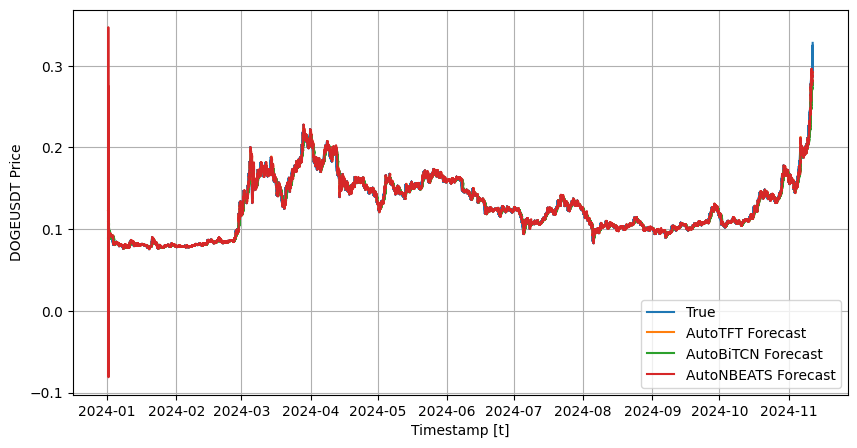

In [8]:
reward_functions=[log_reward_function,cumulative_reward_function,sharpe_reward_function]
train_env,test_env=make_environments.make_envs(reward_function=log_reward_function)


In [9]:
today=datetime.datetime.now().strftime('%Y-%m-%d')
study = optuna.create_study(study_name=f"pearl-2024-11-12-hp-search",
                            directions=["maximize", "maximize"],
                            storage="sqlite:///pearl_hyper_parameters.sqlite3",
                            load_if_exists=True,
                            sampler=TPESampler()
                            )


[I 2024-11-13 17:01:49,786] Using an existing study with name 'pearl-2024-11-12-hp-search' instead of creating a new one.


In [10]:
# print(f"Best value: {study.best_value} (params: {study.best_params})")
best_trials=study.best_trials
best_trials

[FrozenTrial(number=16, state=TrialState.COMPLETE, values=[1084.2016722520668, 117.84], datetime_start=datetime.datetime(2024, 11, 12, 13, 32, 22, 388417), datetime_complete=datetime.datetime(2024, 11, 12, 13, 35, 46, 59501), params={'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 13, 'learning_rate': 3.53300011287604e-05, 'discount_factor': 0.8516537625726973, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.6916880729632867, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9985474810108794, 'learn_after_episode': False, 'learning_steps': 10, 'n_epochs': 500}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'reward_function': CategoricalDistribution(choices=(0, 1, 2)), 'algorithm': CategoricalDistribution(choices=('dqn', 'ddqn')), 'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'n_units': CategoricalDistribution(choices=(64, 128, 256, 512)), 'training_rounds': IntDistr

In [11]:
def load_agent_from_study(study_path,study_name):
    study = optuna.create_study(study_name=study_name,
                            directions=["maximize", "maximize"],
                            storage=study_path,
                            load_if_exists=True,
                            )
    best_trials=study.best_trials
    best_trail=best_trials[2]
    best_params=best_trail.params
    reward_func=reward_functions[best_params.pop('reward_function')]
    train_env.reward_func=reward_func
    test_env.reward_func=reward_func

    algo=best_params.pop('algorithm')

    learning_params={'learn_after_episode':best_params.pop('learn_after_episode'),
                        'learning_steps':best_params.pop('learning_steps'),
                        'n_epochs':best_params.pop('n_epochs'),
                        }
    best_params['hidden_dims']=make_hidden_dims(n_layers=best_params.pop('n_layers'),n_units=best_params.pop('n_units'))
    best_params['lstm']=best_params.pop('use_lstm')
    best_params['observation_space_dim']=train_env.observation_space.shape[0]
    best_params['action_space_dim']=len(train_env.positions)
    if algo=='dqn':
        agent=pearl_utils.create_dqn_model(**best_params)
    elif algo=='ddqn':
        agent=pearl_utils.create_ddqn_model(**best_params)
    
    return agent,learning_params

def load_agent_weights(agent,weight_path):
    weights=pickle.load(open(weight_path,'rb'))
    agent.policy_learner.load_state_dict(weights)
    return agent

def train_production_agent(agent,learning_params,train_env,test_env,save_path):
    agent=pearl_utils.train_pearl_model(agent,train_env,**learning_params)

    profit,n_trades=pearl_utils.test_pearl_model(agent,test_env)
    print(f"Testing Return AVG Profit: {profit}, AVG Number of Trades: {n_trades}")
    agent=pearl_utils.train_pearl_model(agent,test_env,**learning_params)
    pickle.dump(agent.policy_learner.state_dict(),open(save_path,'wb'))
    return agent

In [12]:


if -1 in [np.sign(p) for p in test_env.positions]:
    market_type='Futures'
else:
    market_type='Spot'
symb=target_pair.replace('/','')

agent_path=f'Agent/pearl_{symb}_{market_type}_model.pkl'

agent_path


'Agent/pearl_DOGEUSDT_Spot_model.pkl'

In [13]:
agent,learning_params=pearl_utils.load_agent_from_study(study_path="sqlite:///pearl_hyper_parameters.sqlite3",
                                            study_name='pearl-2024-11-12-hp-search',
                                            action_space_dim=2,
                                            observation_space_dim=30,)

agent=pearl_utils.train_production_agent(agent,
                             learning_params,
                             train_env=train_env,
                             test_env=train_env,
                             save_path=agent_path)

[I 2024-11-13 17:01:49,945] Using an existing study with name 'pearl-2024-11-12-hp-search' instead of creating a new one.
  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:44<?, ?it/s]


Testing Return AVG Profit: 1007.6721884964277, AVG Number of Trades: 4.23


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:44<?, ?it/s]


In [14]:
# pickle.dump(agent.policy_learner.state_dict(),open(agent_path,'wb'))

In [15]:
# weights=pickle.load(open(agent_path,'rb'))

In [16]:
# agent.policy_learner.load_state_dict(weights)

In [18]:

agent,learning_params=pearl_utils.load_agent_from_study(study_path="sqlite:///pearl_hyper_parameters.sqlite3",
                                        study_name='pearl-2024-11-12-hp-search',
                                        action_space_dim=2,
                                        observation_space_dim=30)
agent=load_agent_weights(agent,weight_path=agent_path)

[I 2024-11-13 17:04:49,257] Using an existing study with name 'pearl-2024-11-12-hp-search' instead of creating a new one.


In [19]:
profit,n_trades=pearl_utils.test_pearl_model(agent,test_env)
print(f"Testing Return AVG Profit: {profit}, AVG Number of Trades: {n_trades}")

Testing Return AVG Profit: 1013.7761923797775, AVG Number of Trades: 65.14
